In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ---------------- Constants ----------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
R = 0.01
Tenv = 20.0
T0 = 100.0

In [3]:
# ---------------- Generate Noisy Data ----------------
np.random.seed(42)
t_data = np.linspace(200, 400, 10).reshape(-1, 1)
T_exact = Tenv + (T0 - Tenv) * np.exp(-R * t_data)
noise = np.random.normal(0, 5., size=T_exact.shape)
T_noisy = T_exact + noise

# Normalize time to [0, 1]
t_data_norm = t_data / 1000.0

# Normalize temperature to [0, 1]
T_min = T_noisy.min()
T_max = T_noisy.max()
T_noisy_norm = (T_noisy - T_min) / (T_max - T_min)

# Convert to torch tensors
t_tensor = torch.tensor(t_data_norm, dtype=torch.float32).to(DEVICE)
T_tensor = torch.tensor(T_noisy_norm, dtype=torch.float32).to(DEVICE)

In [4]:
# ---------------- Define Model ----------------
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        return self.net(t)

In [5]:
def train_on_data(model, inputs, targets, lr=1e-4, epochs=10000):
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [6]:
# ---------------- Plotting ----------------
def plot_prediction(model):
    model.eval()
    with torch.no_grad():
        # Use full time range for smooth curve
        t_plot = np.linspace(0, 500, 1000).reshape(-1, 1)
        t_plot_norm = t_plot / 1000.0
        t_plot_tensor = torch.tensor(t_plot_norm, dtype=torch.float32).to(DEVICE)

        pred_norm = model(t_plot_tensor).cpu().numpy()
        pred = pred_norm * (T_max - T_min) + T_min  # denormalize

        T_true = Tenv + (T0 - Tenv) * np.exp(-R * t_plot)

    plt.figure(figsize=(10, 5))
    plt.plot(t_plot, T_true, label="Analytic", linewidth=2)
    plt.plot(t_plot, pred, '--', label="NN Prediction")
    plt.scatter(t_data, T_noisy, color='red', s=10, alpha=0.4, label="Noisy Data")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.title("NN Trained on Noisy Data (with normalization)")
    plt.legend()
    plt.grid(True)
    plt.show()



Epoch 0, Loss: 0.7301
Epoch 500, Loss: 0.0899
Epoch 1000, Loss: 0.0675
Epoch 1500, Loss: 0.0607
Epoch 2000, Loss: 0.0605
Epoch 2500, Loss: 0.0605
Epoch 3000, Loss: 0.0605
Epoch 3500, Loss: 0.0605
Epoch 4000, Loss: 0.0605
Epoch 4500, Loss: 0.0605
Epoch 5000, Loss: 0.0604
Epoch 5500, Loss: 0.0604
Epoch 6000, Loss: 0.0604
Epoch 6500, Loss: 0.0603
Epoch 7000, Loss: 0.0602
Epoch 7500, Loss: 0.0601
Epoch 8000, Loss: 0.0601
Epoch 8500, Loss: 0.0601
Epoch 9000, Loss: 0.0601
Epoch 9500, Loss: 0.0601


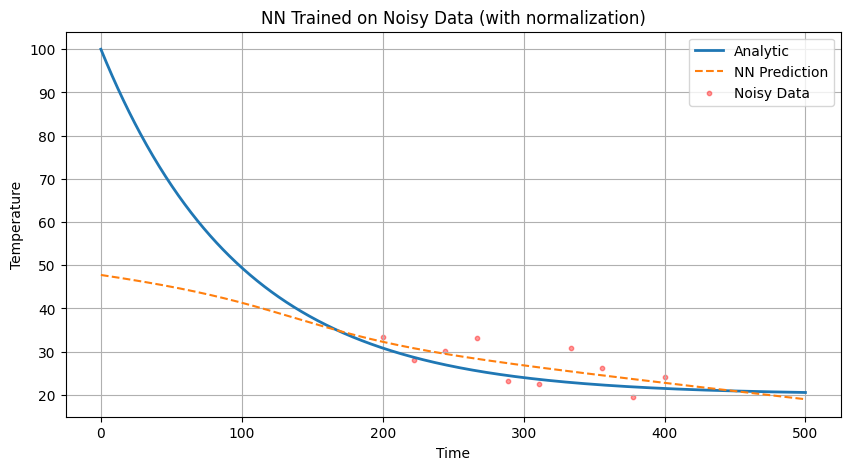

In [7]:
# ---------------- Run ----------------
model = Net()
train_on_data(model, t_tensor, T_tensor)
plot_prediction(model)